In [3]:
# ========================= Jupyter cell: global vs per-feature (TRAIN only) with log scales & FDR =========================
# What this cell does (TRAIN only):
#   1) Global density (all features) for Cases vs Controls, Y-axis in log scale (and robust to zeros).
#   2) Scatter of per-feature medians (Cases vs Controls), both axes in symlog (handles <=0).
#   3) Per-feature boxplots (for N features): RAW (left) vs PROCESSED (right) — TEST removed.
#   4) Global distribution tests (KS, Mann–Whitney) on TRAIN (flattened features).
#   5) Per-feature tests with multiple corrections: BH, BY (FDR), Holm, Bonferroni. Effect sizes included.
#   6) Global descriptive stats CSV for TRAIN (Cases & Controls).
#
# Performance:
#   - Uses chunked histograms over columns for global densities (works with ~320k features).
#   - Downsamples large groups in boxplots.
#
# Requirements: numpy, pandas, matplotlib, seaborn, scipy

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, mannwhitneyu, ks_2samp

In [ ]:
# ----------------------------- consistent styling -----------------------------
sns.set_theme(style="whitegrid", context="notebook")
PALETTE = sns.color_palette("colorblind", 6)
COLOR_CASES, COLOR_CONTROLS = PALETTE[0], PALETTE[1]
LINESTYLE_TRAIN = "-"

# ----------------------------- helpers -----------------------------
def _ensure_alignment(df_ref: pd.DataFrame, df_other: pd.DataFrame) -> pd.DataFrame:
    """Reindex df_other columns to match df_ref (same feature set required)."""
    if set(df_ref.columns) != set(df_other.columns):
        missing = set(df_ref.columns) - set(df_other.columns)
        extra   = set(df_other.columns) - set(df_ref.columns)
        if missing:
            raise ValueError(f"Missing columns (example): {sorted(list(missing))[:5]}")
        if extra:
            df_other = df_other[[c for c in df_ref.columns if c in df_other.columns]]
    return df_other.reindex(columns=df_ref.columns)

def _chunked_hist_density_from_df(df: pd.DataFrame, bins=512, x_range=(-1,3), chunk_cols=2000, dtype=np.float32):
    """Chunked histogram (all values in df) -> (bin centers, density)."""
    total = np.zeros(bins, dtype=np.float64); edges = None
    for s in range(0, df.shape[1], chunk_cols):
        e = min(s + chunk_cols, df.shape[1])
        block = df.iloc[:, s:e].to_numpy(dtype=dtype, copy=False)
        counts, edges = np.histogram(block.ravel(), bins=bins, range=x_range, density=False)
        total += counts
    if edges is None:
        edges = np.linspace(x_range[0], x_range[1], bins+1)
    width = (x_range[1]-x_range[0]) / bins
    norm = total.sum()
    dens = total / (norm * width) if norm > 0 else total
    centers = (edges[:-1] + edges[1:]) / 2.0
    return centers, dens

def _savefig(path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()

def _downsample_xy(x, y, max_points=100000, rng=np.random.default_rng(42)):
    n = x.size
    if n <= max_points:
        return x, y
    idx = rng.choice(n, size=max_points, replace=False)
    return x[idx], y[idx]

def _bh(pvals):
    p = np.asarray(pvals, float); n = p.size
    order = np.argsort(p); ranks = np.empty(n,int); ranks[order] = np.arange(1,n+1)
    q = p * n / ranks
    q_sort = q[order]; q_sort = np.minimum.accumulate(q_sort[::-1])[::-1]
    q[order] = np.clip(q_sort, 0, 1)
    return q

def _by(pvals):
    p = np.asarray(pvals, float); n = p.size
    c_m = np.sum(1.0/np.arange(1,n+1))  # harmonic number
    order = np.argsort(p); ranks = np.empty(n,int); ranks[order] = np.arange(1,n+1)
    q = p * n / (ranks * c_m)
    q_sort = q[order]; q_sort = np.minimum.accumulate(q_sort[::-1])[::-1]
    q[order] = np.clip(q_sort, 0, 1)
    return q

def _holm(pvals):
    p = np.asarray(pvals, float); n = p.size
    order = np.argsort(p); adj = np.empty(n,float)
    for i, idx in enumerate(order, start=1):
        adj[idx] = min((n - i + 1) * p[idx], 1.0)
    # enforce monotonicity from smallest to largest p
    for i in range(1, n):
        if adj[order[i]] < adj[order[i-1]]:
            adj[order[i]] = adj[order[i-1]]
    return adj

def _bonferroni(pvals):
    p = np.asarray(pvals, float); return np.clip(p * p.size, 0, 1)

# ---- robust mapping for top-features (list / CSV / DataFrame) ----
def _resolve_top_features(top_features, df_ref: pd.DataFrame, topn=20,
                          feature_source_columns=("feature_name","feature_index","feature","index"),
                          assume_positional=False):
    vals = None
    if isinstance(top_features, (str, os.PathLike)):
        tf_df = pd.read_csv(top_features)
    elif isinstance(top_features, pd.DataFrame):
        tf_df = top_features.copy()
    else:
        vals = pd.Index(pd.unique(pd.Series(top_features))).tolist()

    if vals is None:
        col = None
        for cand in feature_source_columns:
            if cand in tf_df.columns: col = cand; break
        if col is None:
            for c in tf_df.columns:
                if c.lower() not in ("fold","rank"): col = c; break
        if col is None: raise ValueError("Cannot find a feature id column in top-features.")
        if "rank" in tf_df.columns:
            tf_df = tf_df.sort_values(["fold","rank"], kind="stable") if "fold" in tf_df.columns \
                    else tf_df.sort_values(["rank"], kind="stable")
        vals = pd.unique(tf_df[col])[:topn].tolist()

    cols = pd.Index(df_ref.columns); cols_str = cols.map(str); vals_str = pd.Series(vals).map(str)
    mask = cols_str.isin(set(vals_str)); matched = cols[mask].tolist()

    if not matched:
        cols_num = pd.to_numeric(cols, errors="coerce"); vals_num = pd.to_numeric(pd.Series(vals), errors="coerce")
        if cols_num.notna().any() and vals_num.notna().any():
            num2name = {}
            for cnum, cname in zip(cols_num, cols):
                if pd.notna(cnum) and cnum not in num2name: num2name[cnum] = cname
            tmp = []
            for v in vals_num:
                if pd.notna(v) and v in num2name: tmp.append(num2name[v])
            matched = list(pd.unique(pd.Series(tmp)))[:topn]

    if (assume_positional or not matched):
        try:
            idx = pd.Series(vals).astype(int).to_numpy()
            ok = (idx >= 0) & (idx < cols.size)
            if ok.any(): matched = cols[idx[ok]].tolist()[:topn]
            if not matched:
                idx1 = idx - 1; ok1 = (idx1 >= 0) & (idx1 < cols.size)
                if ok1.any(): matched = cols[idx1[ok1]].tolist()[:topn]
        except Exception:
            pass

    if not matched:
        raise ValueError("No top_features match DataFrame columns.")
    order = {str(v): i for i, v in enumerate(vals)}
    matched = sorted(matched, key=lambda x: order.get(str(x), 1e12))[:topn]
    return matched

# ---- RAW column mapper (processed feature name -> raw column name) ----
class RawMapper:
    _token_re = re.compile(r"(\d+)")
    def __init__(self, raw_df: pd.DataFrame, ref_cols: pd.Index):
        self.raw_cols = pd.Index(raw_df.columns)
        self.ref_cols = pd.Index(ref_cols)
        self._raw_str_to_col = {str(c): c for c in self.raw_cols}
        raw_num = pd.to_numeric(self.raw_cols, errors="coerce")
        self._raw_num_to_col = {}
        for num, name in zip(raw_num, self.raw_cols):
            if pd.notna(num) and num not in self._raw_num_to_col:
                self._raw_num_to_col[num] = name
        self._raw_token_to_col = {}
        for name in self.raw_cols.map(str):
            m = self._token_re.search(name)
            if m:
                val = float(m.group(1))
                if val not in self._raw_token_to_col:
                    self._raw_token_to_col[val] = name

    def map_feature(self, feat):
        s = str(feat)
        if s in self._raw_str_to_col: return self._raw_str_to_col[s]
        try:
            fnum = float(feat)
            if fnum in self._raw_num_to_col: return self._raw_num_to_col[fnum]
            if fnum in self._raw_token_to_col: return self._raw_token_to_col[fnum]
        except Exception:
            pass
        if len(self.raw_cols) == len(self.ref_cols):
            try:
                pos = self.ref_cols.get_loc(feat)
                return self.raw_cols[pos]
            except Exception:
                pass
        return None

# ---- small helpers for titles/numbers ----
_num_token_re = re.compile(r"(\d+)")
def _pretty_num_token(feat_name):
    m = _num_token_re.search(str(feat_name))
    return m.group(1) if m else str(feat_name)

def _box2_on_axis(ax, data_ctrl, data_case, title, ylabel=None,
                  colors=(COLOR_CONTROLS, COLOR_CASES), max_samps=12000, rng=np.random.default_rng(42)):
    """Two-group boxplot on provided axis."""
    def _cap(a):
        a = pd.Series(a).dropna()
        if a.shape[0] > max_samps:
            return a.sample(n=max_samps, random_state=int(rng.integers(1_000_000)))
        return a
    d_ctrl = _cap(data_ctrl); d_case = _cap(data_case)
    bp = ax.boxplot([d_ctrl, d_case], positions=[1,2], widths=0.7, showfliers=False, patch_artist=True)
    for patch, c in zip(bp["boxes"], colors):
        patch.set_facecolor(c); patch.set_alpha(0.6)
    for med in bp["medians"]:
        med.set_color("black"); med.set_linewidth(1.4)
    ax.set_xticks([1,2]); ax.set_xticklabels(["Controls","Cases"])
    ax.set_title(title)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True, axis="y", alpha=0.2)

# ----------------------------- main function -----------------------------
def visualize_group_differences(
    train_cases: pd.DataFrame,
    train_controls: pd.DataFrame,
    test_cases: pd.DataFrame,     # kept for interface compatibility (unused in plots)
    test_controls: pd.DataFrame,  # kept for interface compatibility (unused in plots)
    top_features,                  # list | CSV path | DataFrame
    train_cases_raw: pd.DataFrame = None,
    train_controls_raw: pd.DataFrame = None,
    test_cases_raw: pd.DataFrame = None,      # unused in plots
    test_controls_raw: pd.DataFrame = None,   # unused in plots
    outdir: str = "./group_diff_plots",
    density_bins: int = 512,
    density_range: tuple = (-1, 3),
    chunk_cols: int = 2000,
    max_scatter_points: int = 100000,
    max_features_tests: int = 50000,
    boxplot_max_samples: int = 12000,
    seed: int = 42,
    topn: int = 20,
    feature_source_columns=("feature_name","feature_index","feature","index"),
    assume_positional_top: bool = False,
    cases_tag: str = "<5 ytd",
    n_features_for_plots: int = 10
):
    rng = np.random.default_rng(seed)

    # Align TRAIN processed sets (same features)
    train_controls = _ensure_alignment(train_cases, train_controls)

    # RAW fallbacks (TRAIN)
    if train_cases_raw is None:     train_cases_raw = train_cases
    if train_controls_raw is None:  train_controls_raw = train_controls

    os.makedirs(outdir, exist_ok=True)
    features_dir = os.path.join(outdir, "features")
    os.makedirs(features_dir, exist_ok=True)

    # Resolve top features on TRAIN processed
    tf_all = _resolve_top_features(top_features, df_ref=train_cases, topn=topn,
                                   feature_source_columns=feature_source_columns,
                                   assume_positional=assume_positional_top)
    tf = tf_all[:n_features_for_plots]

    # RAW mapper (TRAIN)
    ref_cols = pd.Index(train_cases.columns)
    mapper_train_cases_raw    = RawMapper(train_cases_raw,    ref_cols)
    mapper_train_controls_raw = RawMapper(train_controls_raw, ref_cols)

    # -------------------------------- 1) GLOBAL density (TRAIN) — log Y --------------------------------
    # PROCESSED
    x_c, d_c = _chunked_hist_density_from_df(train_cases,   bins=density_bins, x_range=density_range, chunk_cols=chunk_cols)
    x_n, d_n = _chunked_hist_density_from_df(train_controls, bins=density_bins, x_range=density_range, chunk_cols=chunk_cols)
    eps = 1e-12
    d_c = np.clip(d_c, eps, None); d_n = np.clip(d_n, eps, None)

    plt.figure(figsize=(10, 5))
    sns.lineplot(x=x_c, y=d_c, label="TRAIN Cases (processed)", color=COLOR_CASES, linestyle=LINESTYLE_TRAIN)
    sns.lineplot(x=x_n, y=d_n, label="TRAIN Controls (processed)", color=COLOR_CONTROLS, linestyle=LINESTYLE_TRAIN)
    plt.xlim(density_range); plt.yscale("log")
    plt.xlabel("Feature value"); plt.ylabel("Density (log scale)")
    plt.title("Global density – TRAIN (processed) | Cases vs Controls")
    _savefig(os.path.join(outdir, "global_density_TRAIN_processed_logY.png"))

    # RAW (optional)
    if (train_cases_raw is not None) and (train_controls_raw is not None):
        xr_c, dr_c = _chunked_hist_density_from_df(train_cases_raw,   bins=density_bins, x_range=density_range, chunk_cols=chunk_cols)
        xr_n, dr_n = _chunked_hist_density_from_df(train_controls_raw, bins=density_bins, x_range=density_range, chunk_cols=chunk_cols)
        dr_c = np.clip(dr_c, eps, None); dr_n = np.clip(dr_n, eps, None)
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=xr_c, y=dr_c, label="TRAIN Cases (raw)", color=COLOR_CASES, linestyle=LINESTYLE_TRAIN)
        sns.lineplot(x=xr_n, y=dr_n, label="TRAIN Controls (raw)", color=COLOR_CONTROLS, linestyle=LINESTYLE_TRAIN)
        plt.xlim(density_range); plt.yscale("log")
        plt.xlabel("Feature value"); plt.ylabel("Density (log scale)")
        plt.title("Global density – TRAIN (raw) | Cases vs Controls")
        _savefig(os.path.join(outdir, "global_density_TRAIN_raw_logY.png"))

    # -------------------------------- 2) SCATTER of per-feature medians (TRAIN) — symlog axes --------------------------------
    med_train_cases    = train_cases.median(axis=0).to_numpy()
    med_train_controls = train_controls.median(axis=0).to_numpy()

    # Correlations on ALL features
    r_p, p_p = pearsonr(med_train_cases, med_train_controls)
    r_s, p_s = spearmanr(med_train_cases, med_train_controls)

    xs, ys = _downsample_xy(med_train_cases, med_train_controls, max_points=max_scatter_points, rng=rng)
    plt.figure(figsize=(7.8, 7.2))
    sns.scatterplot(x=xs, y=ys, s=10, color=PALETTE[2])
    # y=x reference
    mn = float(min(med_train_cases.min(), med_train_controls.min()))
    mx = float(max(med_train_cases.max(), med_train_controls.max()))
    plt.plot([mn, mx], [mn, mx], color="black", linewidth=1)
    plt.xlabel("Train per-feature median (Cases)")
    plt.ylabel("Train per-feature median (Controls)")
    plt.title(f"Per-feature medians (TRAIN) – symlog axes\nPearson r={r_p:.3f} (p={p_p:.2e}) | Spearman ρ={r_s:.3f} (p={p_s:.2e})")
    # Set symlog scales (handles <=0)
    plt.xscale("symlog", linthresh=1e-3); plt.yscale("symlog", linthresh=1e-3)
    _savefig(os.path.join(outdir, "scatter_medians_TRAIN_symlog.png"))

    # -------------------------------- 3) Per-feature BOXPLOTS (TRAIN): RAW (left) vs PROCESSED (right) --------------------------------
    def _cap_rows(df, cap, rng):
        return df.sample(n=cap, random_state=int(rng.integers(1_000_000)), replace=False) if df.shape[0] > cap else df

    feature_plot_paths = []
    for f in tf:
        # map raw columns for this processed feature
        raw_f_tc = mapper_train_cases_raw.map_feature(f)
        raw_f_tr = mapper_train_controls_raw.map_feature(f)
        if (raw_f_tc is None) or (raw_f_tr is None):
            print(f"[WARN] RAW TRAIN: could not map feature '{f}' (cases→{raw_f_tc}, controls→{raw_f_tr}); skipping.")
            continue

        num_disp = _pretty_num_token(f)

        raw_case = _cap_rows(train_cases_raw[[raw_f_tc]], boxplot_max_samples, rng)[raw_f_tc].to_numpy()
        raw_ctrl = _cap_rows(train_controls_raw[[raw_f_tr]], boxplot_max_samples, rng)[raw_f_tr].to_numpy()
        proc_case = _cap_rows(train_cases[[f]], boxplot_max_samples, rng)[f].to_numpy()
        proc_ctrl = _cap_rows(train_controls[[f]], boxplot_max_samples, rng)[f].to_numpy()

        fig, axes = plt.subplots(1, 2, figsize=(12, 5.2), sharey=False)

        # Left: RAW (Beta values)
        title_raw = f"Posición ({num_disp}): Beta values Cases ({cases_tag}) vs Controls"
        _box2_on_axis(axes[0], raw_ctrl,  raw_case,  title=title_raw, ylabel="Value",
                      colors=(COLOR_CONTROLS, COLOR_CASES), max_samps=boxplot_max_samples, rng=rng)

        # Right: PROCESSED (REC values)
        title_proc = f"Position ({num_disp}): REC values Cases ({cases_tag}) vs Controls"
        _box2_on_axis(axes[1], proc_ctrl, proc_case, title=title_proc, ylabel=None,
                      colors=(COLOR_CONTROLS, COLOR_CASES), max_samps=boxplot_max_samples, rng=rng)

        plt.tight_layout()
        fpath = os.path.join(features_dir, f"feature_{f}_box_train_RAW_vs_PROCESSED.png")
        _savefig(fpath)
        feature_plot_paths.append(fpath)

    # -------------------------------- 4) Global distribution tests (TRAIN) --------------------------------
    # Flatten (careful with memory): we go by chunks across columns to collect valid values
    def _flatten_values(df, chunk_cols=2000, dtype=np.float32):
        vals = []
        for s in range(0, df.shape[1], chunk_cols):
            e = min(s + chunk_cols, df.shape[1])
            block = df.iloc[:, s:e].to_numpy(dtype=dtype, copy=False).ravel()
            block = block[np.isfinite(block)]
            vals.append(block)
        if not vals: 
            return np.array([], dtype=dtype)
        return np.concatenate(vals, axis=0)

    flat_cases = _flatten_values(train_cases, chunk_cols=chunk_cols)
    flat_ctrls = _flatten_values(train_controls, chunk_cols=chunk_cols)

    try:
        p_mw_global = mannwhitneyu(flat_cases, flat_ctrls, alternative="two-sided").pvalue if (flat_cases.size and flat_ctrls.size) else np.nan
    except Exception:
        p_mw_global = np.nan
    try:
        p_ks_global = ks_2samp(flat_cases, flat_ctrls, alternative="two-sided", mode="auto").pvalue if (flat_cases.size and flat_ctrls.size) else np.nan
    except Exception:
        p_ks_global = np.nan

    pd.DataFrame([{"test":"Mann-Whitney (global TRAIN)", "p_value":p_mw_global},
                  {"test":"KS (global TRAIN)",            "p_value":p_ks_global}]
    ).to_csv(os.path.join(outdir, "global_distribution_tests.csv"), index=False)

    # -------------------------------- 5) Per-feature tests with multiple corrections (TRAIN) --------------------------------
    # Optionally limit number of features to keep runtime reasonable
    all_feats = train_cases.columns.to_numpy()
    if (max_features_tests is not None) and (all_feats.size > max_features_tests):
        feats_tested = np.sort(np.random.default_rng(seed).choice(all_feats, size=max_features_tests, replace=False))
    else:
        feats_tested = all_feats

    rows = []
    for f in feats_tested:
        x = train_cases[f].to_numpy(); x = x[np.isfinite(x)]
        y = train_controls[f].to_numpy(); y = y[np.isfinite(y)]
        if x.size == 0 or y.size == 0:
            mw_p = np.nan; ks_p = np.nan; u_stat = np.nan; auc_eff = np.nan
            med_diff = np.nan
            nx, ny = x.size, y.size
        else:
            try:
                res = mannwhitneyu(x, y, alternative="two-sided")
                mw_p = res.pvalue; u_stat = res.statistic
                auc_eff = float(u_stat) / (x.size * y.size)  # effect size ~ P(X>Y) + 0.5*P(X=Y)
            except Exception:
                mw_p = np.nan; u_stat = np.nan; auc_eff = np.nan
            try:
                ks_p = ks_2samp(x, y, alternative="two-sided", mode="auto").pvalue
            except Exception:
                ks_p = np.nan
            med_diff = (np.median(x) if x.size else np.nan) - (np.median(y) if y.size else np.nan)
            nx, ny = x.size, y.size
        rows.append((f, mw_p, ks_p, med_diff, auc_eff, nx, ny))
    feat_df = pd.DataFrame(rows, columns=["feature","p_mannwhitney","p_ks","median_diff","auc_effect","n_cases","n_controls"])

    # Multiple corrections
    for col in ["p_mannwhitney", "p_ks"]:
        p = feat_df[col].fillna(1.0).values
        feat_df[f"q_BH_{col}"]   = _bh(p)
        feat_df[f"q_BY_{col}"]   = _by(p)
        feat_df[f"p_Holm_{col}"] = _holm(p)
        feat_df[f"p_Bonf_{col}"] = _bonferroni(p)

    feat_df = feat_df.sort_values(["q_BH_p_mannwhitney", "q_BH_p_ks"], ascending=True).reset_index(drop=True)
    feat_df.to_csv(os.path.join(outdir, "train_per_feature_tests_with_FDR.csv"), index=False)

    # -------------------------------- 6) Global descriptive stats CSV (TRAIN) --------------------------------
    def _global_stats(df: pd.DataFrame, label: str, bins=4096, x_range=(-1,3), chunk_cols=2000, dtype=np.float32):
        # moments via chunking; quantiles via histogram (approx)
        n = 0
        mean = 0.0
        M2 = 0.0
        M3 = 0.0
        M4 = 0.0
        # histogram for quantiles
        counts = np.zeros(bins, dtype=np.float64)
        edges = np.linspace(x_range[0], x_range[1], bins+1)
        for s in range(0, df.shape[1], chunk_cols):
            e = min(s + chunk_cols, df.shape[1])
            block = df.iloc[:, s:e].to_numpy(dtype=dtype, copy=False).ravel()
            block = block[np.isfinite(block)]
            if block.size == 0:
                continue
            # update histogram
            cnt, _ = np.histogram(block, bins=edges, density=False)
            counts += cnt
            # update moments (West's formulas combining moments)
            n_b = block.size
            mean_b = float(block.mean())
            dev = block - mean_b
            M2_b = float(np.sum(dev**2))
            M3_b = float(np.sum(dev**3))
            M4_b = float(np.sum(dev**4))
            # merge (a = current, b = chunk)
            n_a = n; mean_a = mean; M2_a = M2; M3_a = M3; M4_a = M4
            n = n_a + n_b
            if n == 0: 
                continue
            delta = mean_b - mean_a
            delta2 = delta*delta; delta3 = delta2*delta; delta4 = delta3*delta
            mean = mean_a + delta * (n_b / n)
            M2 = M2_a + M2_b + delta2 * n_a * n_b / n
            M3 = (M3_a + M3_b + delta3 * n_a * n_b * (n_a - n_b) / (n*n) +
                  3.0*delta * (n_a * M2_b - n_b * M2_a) / n)
            M4 = (M4_a + M4_b + delta4 * n_a * n_b * (n_a*n_a - n_a*n_b + n_b*n_b) / (n**3) +
                  6.0*delta2 * (n_a*n_a * M2_b + n_b*n_b * M2_a) / (n*n) +
                  4.0*delta * (n_a * M3_b - n_b * M3_a) / n)

        # finalize stats
        var = M2 / (n - 1) if n > 1 else np.nan
        std = np.sqrt(var) if var == var else np.nan
        skew = (np.sqrt(n) * M3) / (M2**1.5) if (M2 > 0 and n > 2) else np.nan
        kurt = (n * M4) / (M2*M2) - 3.0 if (M2 > 0 and n > 3) else np.nan

        # quantiles approx from histogram
        cdf = np.cumsum(counts)
        total = cdf[-1] if cdf.size else 0
        def q_from_hist(p):
            if total <= 0: return np.nan
            k = np.searchsorted(cdf, p*total, side="left")
            k = np.clip(k, 0, counts.size-1)
            return (edges[k] + edges[k+1]) / 2.0
        q01 = q_from_hist(0.01); q05 = q_from_hist(0.05)
        q25 = q_from_hist(0.25); q50 = q_from_hist(0.50); q75 = q_from_hist(0.75)
        q95 = q_from_hist(0.95); q99 = q_from_hist(0.99)

        # min/max approx from histogram support that has counts
        nonzero = np.where(counts > 0)[0]
        if nonzero.size:
            vmin = edges[nonzero[0]]
            vmax = edges[nonzero[-1] + 1]
        else:
            vmin = np.nan; vmax = np.nan

        return {
            "set": label,
            "n_finite": int(total),
            "mean": mean, "std": std, "var": var,
            "min_approx": vmin, "p01": q01, "p05": q05, "p25": q25, "p50": q50,
            "p75": q75, "p95": q95, "p99": q99, "max_approx": vmax,
            "skewness": skew, "kurtosis_excess": kurt
        }

    stats_cases_proc = _global_stats(train_cases,   label="TRAIN Cases (processed)",
                                     bins=4096, x_range=density_range, chunk_cols=chunk_cols)
    stats_ctrls_proc = _global_stats(train_controls, label="TRAIN Controls (processed)",
                                     bins=4096, x_range=density_range, chunk_cols=chunk_cols)
    rows = [stats_cases_proc, stats_ctrls_proc]

    # RAW stats too (optional)
    if (train_cases_raw is not None) and (train_controls_raw is not None):
        rows.append(_global_stats(train_cases_raw,   label="TRAIN Cases (raw)",
                                  bins=4096, x_range=density_range, chunk_cols=chunk_cols))
        rows.append(_global_stats(train_controls_raw, label="TRAIN Controls (raw)",
                                  bins=4096, x_range=density_range, chunk_cols=chunk_cols))

    pd.DataFrame(rows).to_csv(os.path.join(outdir, "global_descriptive_stats.csv"), index=False)
    print(f"[Saved] Plots and CSVs under: {outdir}\n"
          f" - Global density (processed/raw)\n"
          f" - Scatter medians (symlog)\n"
          f" - Per-feature boxplots in: {features_dir}\n"
          f" - global_distribution_tests.csv\n"
          f" - train_per_feature_tests_with_FDR.csv\n"
          f" - global_descriptive_stats.csv")

In [3]:
# --------------------------------- Example call ---------------------------------
train_cases_df = pd.read_csv("/home/77462217B/lois/AAImageneAnomalyDetection/outcomes/REC/heavymodelv1/All/StdPlus1ScoreMic5CasMSE.csv")
train_controls_df = pd.read_csv("/home/77462217B/lois/AAImageneAnomalyDetection/outcomes/REC/heavymodelv1/All/StdPlus1ScoreMicConMSE.csv")

In [4]:
test_cases_df = pd.read_csv("/home/77462217B/lois/AAImageneAnomalyDetection/outcomes/REC/heavymodelv1/All/StdPlus1ScoreFraCasMSE.csv")
test_controls_df = pd.read_csv("/home/77462217B/lois/AAImageneAnomalyDetection/outcomes/REC/heavymodelv1/All/StdPlus1ScoreFraConMSE.csv")

KeyboardInterrupt: 

In [ ]:
train_controls_raw_df = pd.read_csv("/home/77462217B/lois/AAImageneAnomalyDetection/data/evaluatedatasets/BetasMicCon.csv")
train_cases_raw_df = pd.read_csv("/home/77462217B/lois/AAImageneAnomalyDetection/data/evaluatedatasets/Betas5Mic.csv")

In [ ]:
test_cases_raw_df = pd.DataFrame(np.load("/home/77462217B/lois/AAImageneAnomalyDetection/data/evaluatedatasets/FraCas_float16.npy")).T
test_controls_raw_df = pd.DataFrame(np.load("/home/77462217B/lois/AAImageneAnomalyDetection/data/evaluatedatasets/FraCon_float16.npy")).T

In [ ]:
top_features_list=pd.read_csv("/home/77462217B/lois/AAImageneAnomalyDetection/plots/Mic5/train_per_feature_tests_with_FDR.csv")

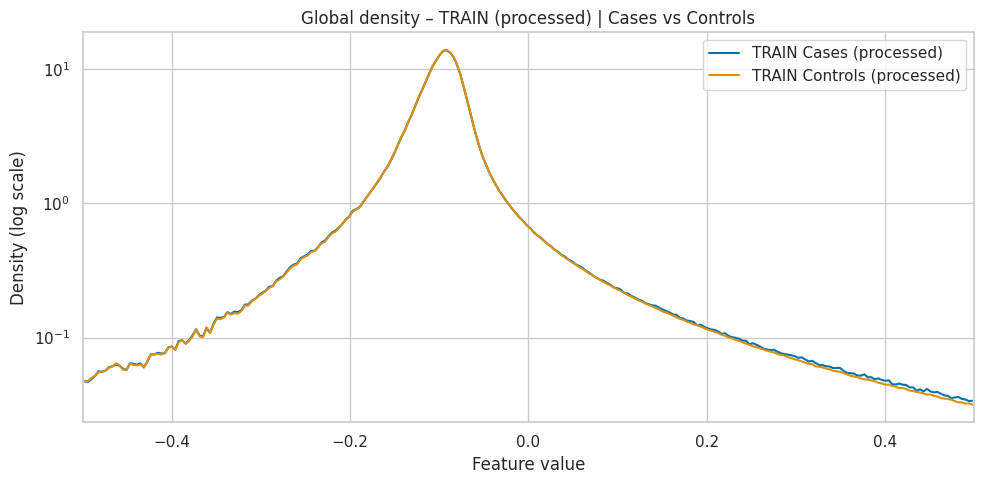

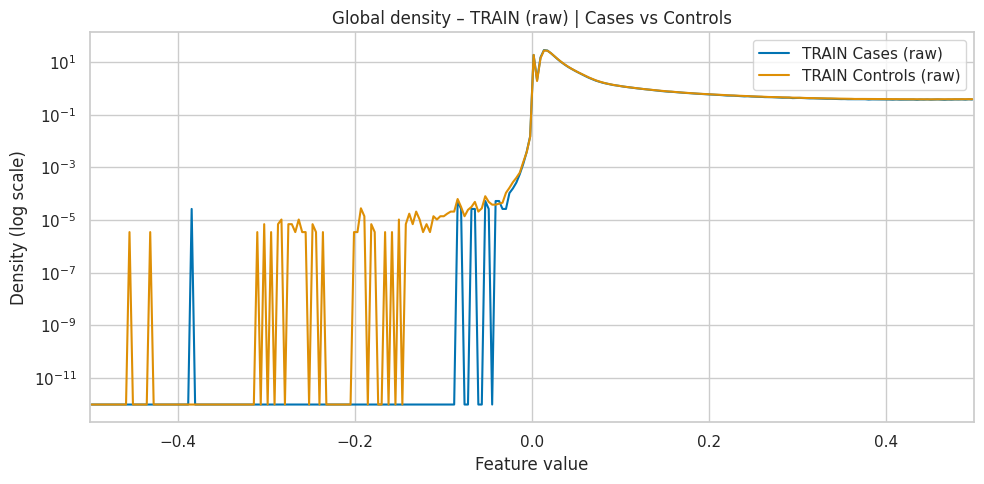

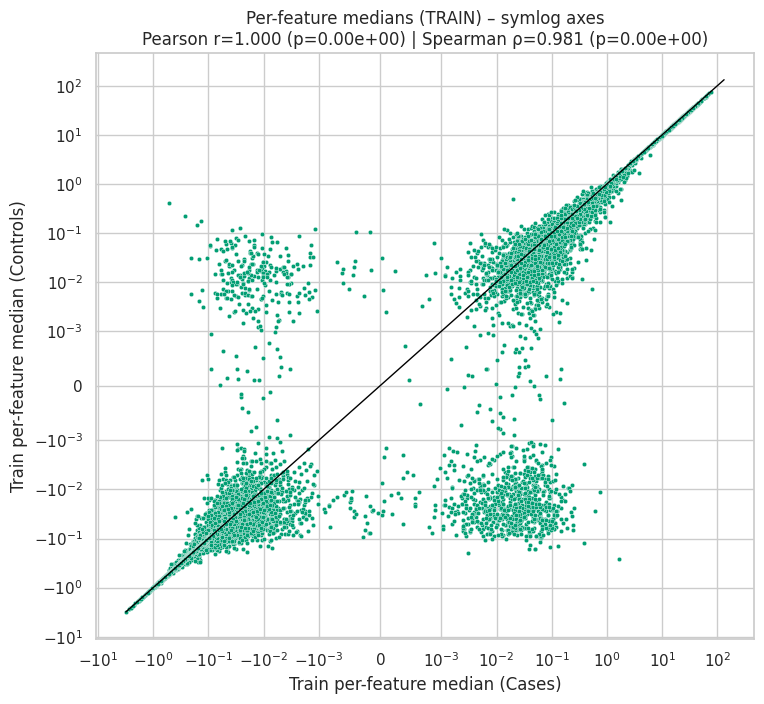

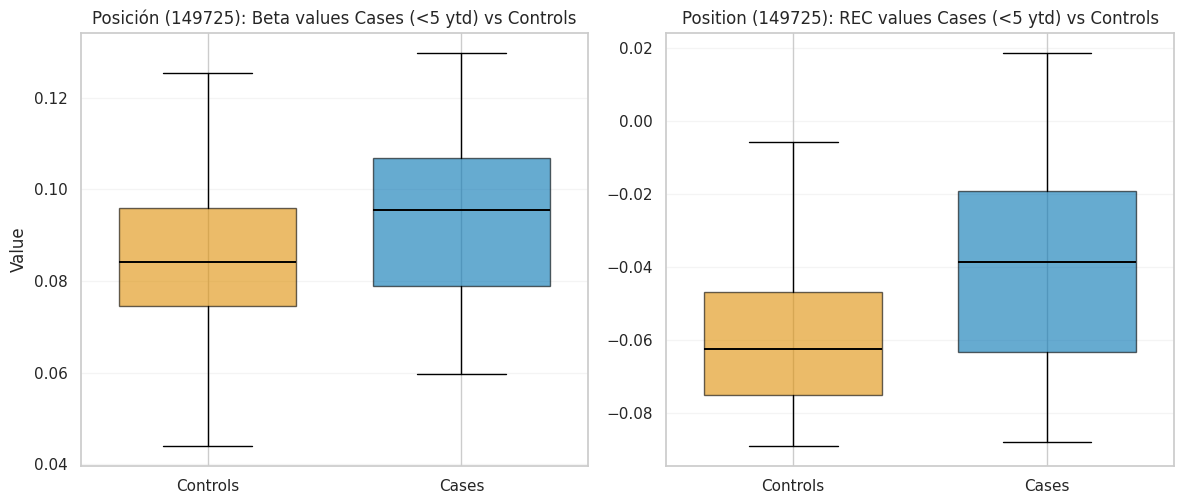

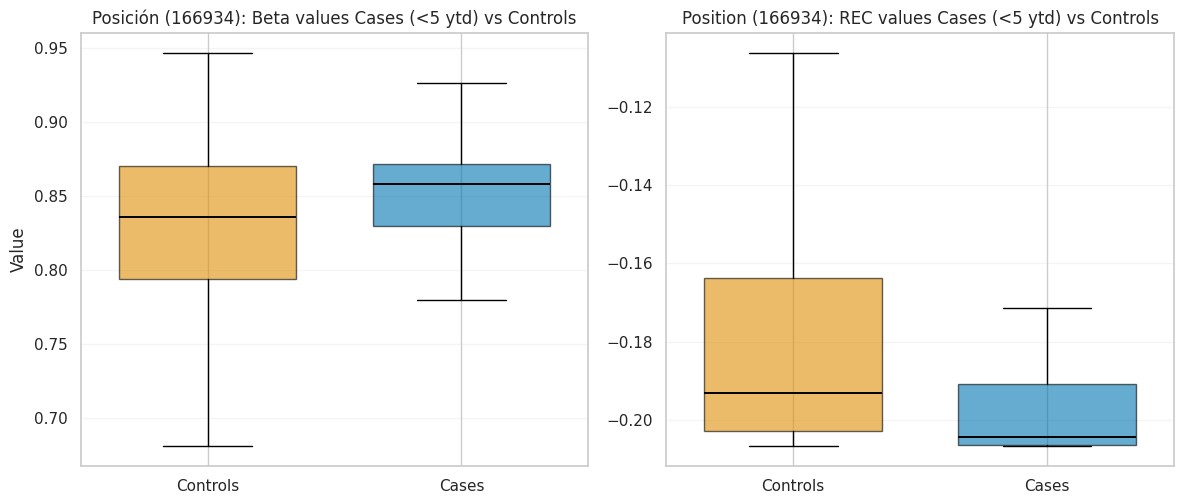

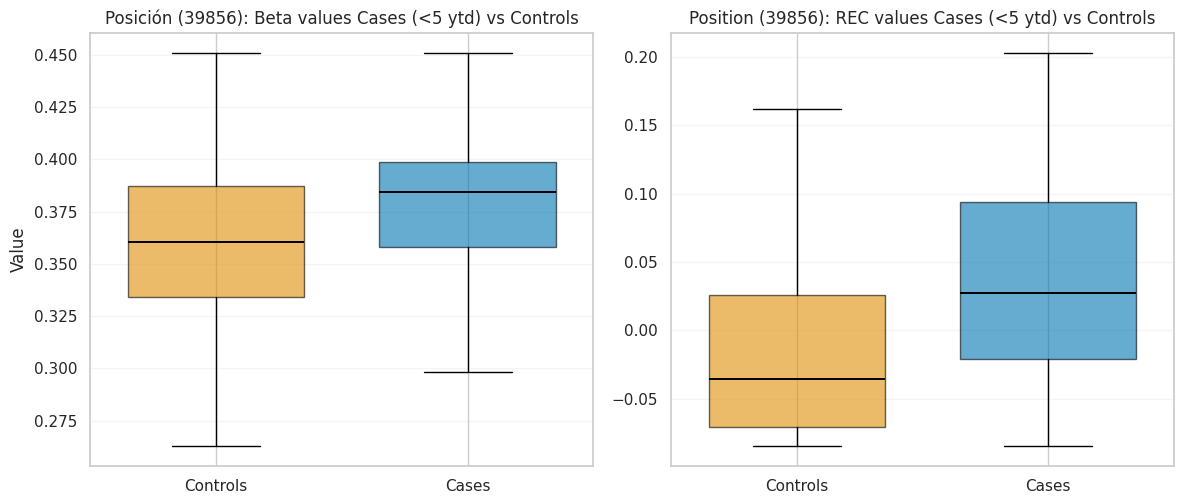

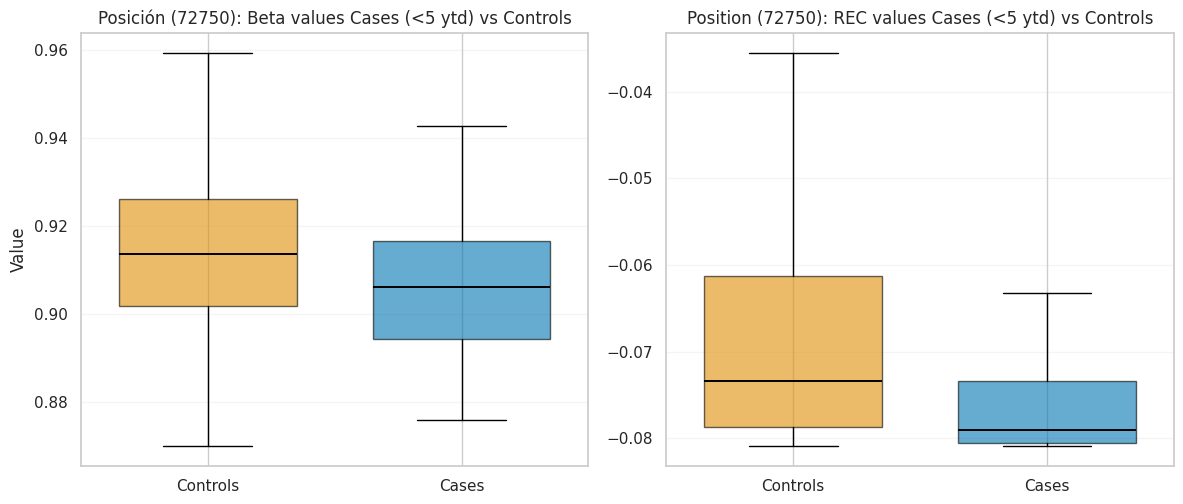

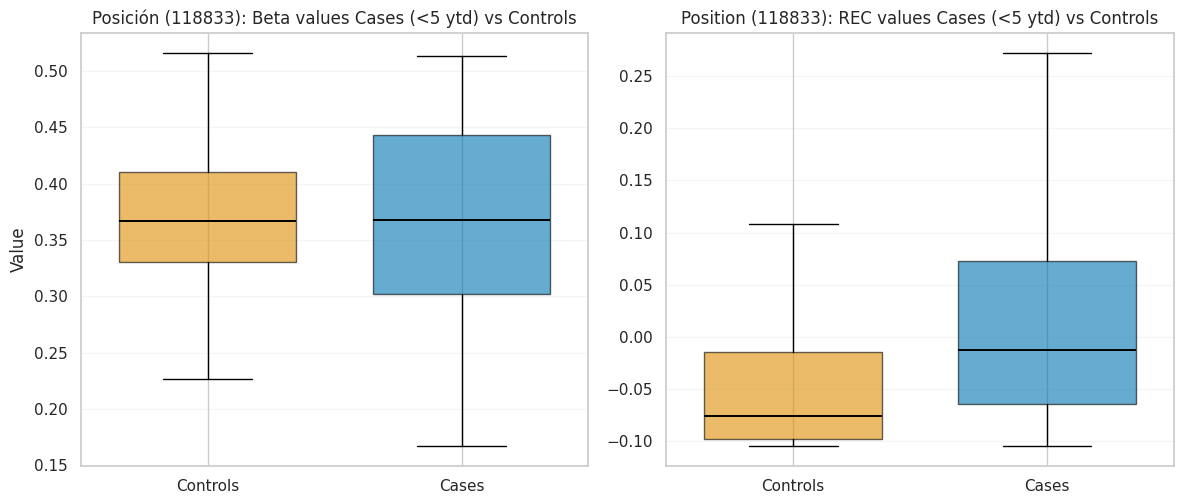

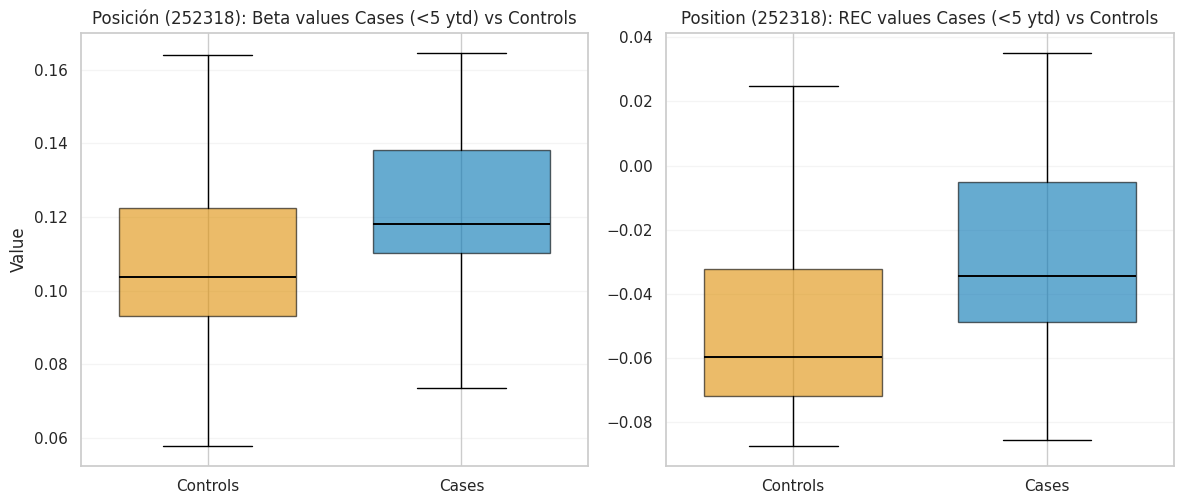

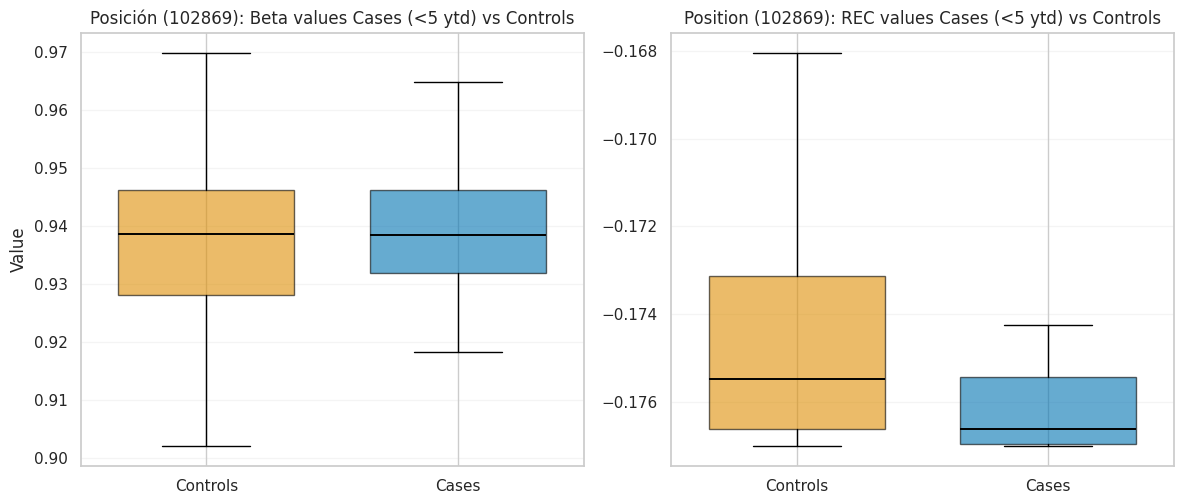

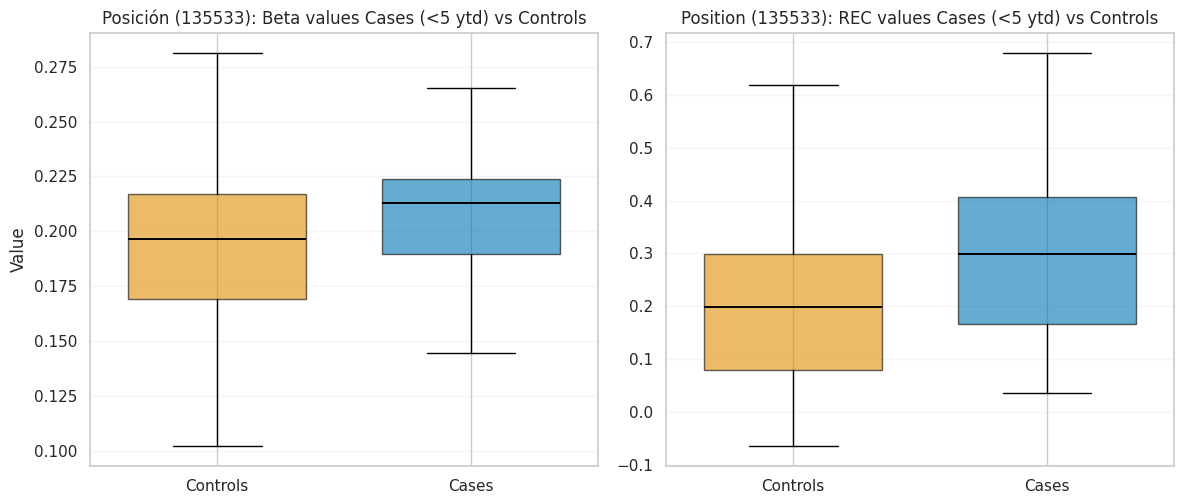

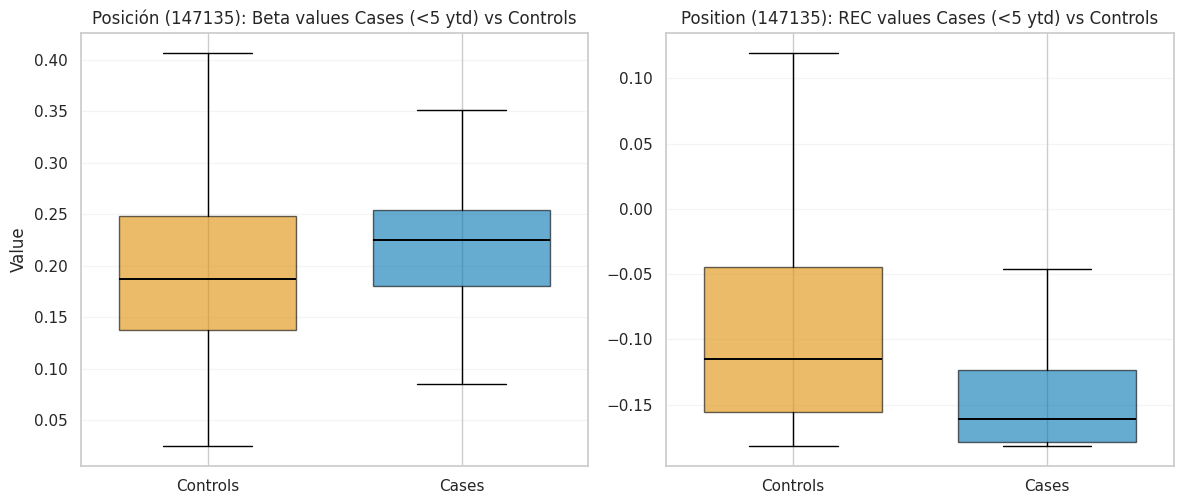

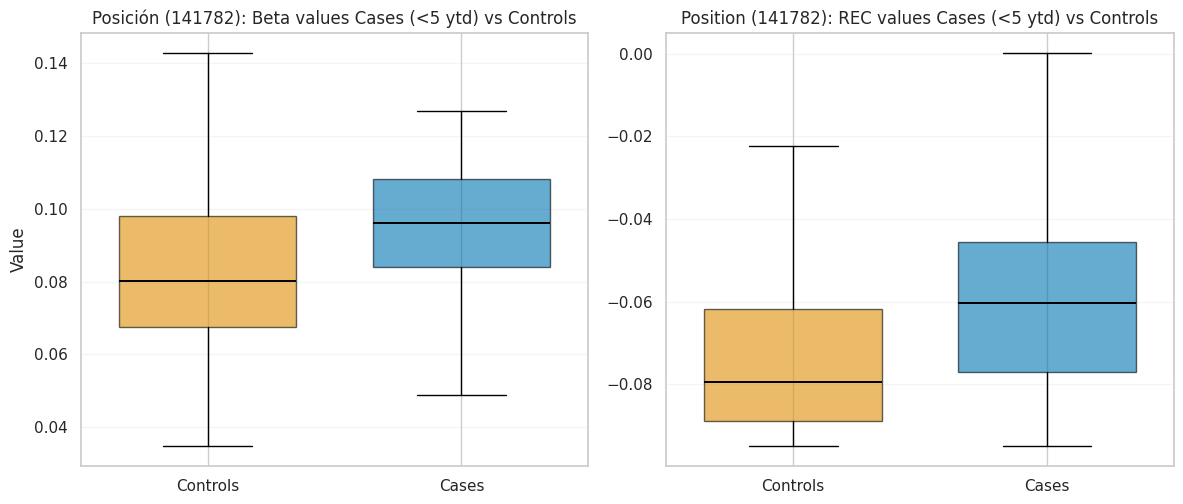

[Saved] Plots and CSVs under: /home/77462217B/lois/AAImageneAnomalyDetection/plots/Mic5
 - Global density (processed/raw)
 - Scatter medians (symlog)
 - Per-feature boxplots in: /home/77462217B/lois/AAImageneAnomalyDetection/plots/Mic5/features
 - global_distribution_tests.csv
 - train_per_feature_tests_with_FDR.csv
 - global_descriptive_stats.csv


In [18]:
visualize_group_differences(
     train_cases_df, train_controls_df, test_cases_df, test_controls_df, top_features_list,
     train_cases_raw=train_cases_raw_df,
     train_controls_raw=train_controls_raw_df,
     test_cases_raw=test_cases_raw_df,
     test_controls_raw=test_controls_raw_df,
     outdir="/home/77462217B/lois/AAImageneAnomalyDetection/plots/Mic5",
     density_bins=256, density_range=(-0.5, 0.5), chunk_cols=2000,
     max_scatter_points=80000, max_features_tests=320000, seed=42)

In [ ]:
# ========================= Jupyter cell: Global stats (standalone) =========================
# Computes robust global stats over ALL values in a wide DataFrame (rows=samples, cols=features)
# using column-chunking to keep memory low. Quantiles are approximated via a histogram
# over a fixed x-range. Results are saved as a single-row CSV.

import os
import numpy as np
import pandas as pd

def save_global_stats(
    df: pd.DataFrame,
    out_csv_path: str,
    label: str = "DATA",
    bins: int = 4096,
    x_range: tuple = (-1, 3),       # adjust if your value range differs
    chunk_cols: int = 2000,         # number of columns per chunk
    dtype = np.float32,
    overwrite: bool = True          # if False, append a new row (header written only if file doesn't exist)
):
    """
    Compute global descriptive statistics for all finite values in `df` and save to CSV.

    Stats reported:
      - n_finite, mean, std, var
      - min_approx, p01, p05, p25, p50, p75, p95, p99, max_approx  (histogram-based)
      - skewness, kurtosis_excess (via pooled central moments)

    Parameters
    ----------
    df : pd.DataFrame
        Wide matrix (rows = samples, columns = features) with numeric values.
    out_csv_path : str
        Destination CSV path (one row).
    label : str
        Identifier written in the 'set' column.
    bins : int
        Number of histogram bins (larger -> finer quantile approx; higher cost).
    x_range : (float, float)
        Histogram range used for quantiles (values outside are clipped into edge bins).
    chunk_cols : int
        Columns processed per chunk to control memory.
    dtype : numpy dtype
        Internal dtype for numeric ops.
    overwrite : bool
        If True, write/overwrite file with one row. If False, append row.

    Returns
    -------
    pd.DataFrame (shape 1×N) with the computed stats.
    """

    # --- Initialize pooled moments and histogram ---
    n = 0
    mean = 0.0
    M2 = 0.0
    M3 = 0.0
    M4 = 0.0

    edges = np.linspace(x_range[0], x_range[1], bins + 1)
    counts = np.zeros(bins, dtype=np.float64)

    # --- Process by column chunks ---
    for start in range(0, df.shape[1], chunk_cols):
        stop = min(start + chunk_cols, df.shape[1])
        block = df.iloc[:, start:stop].to_numpy(dtype=dtype, copy=False).ravel()
        block = block[np.isfinite(block)]
        if block.size == 0:
            continue

        # Update histogram (quantile approximation)
        cnt, _ = np.histogram(block, bins=edges, density=False)
        counts += cnt

        # Update pooled moments (West/Chan parallel formulas)
        nb = block.size
        mean_b = float(block.mean())
        # central moments of the block
        dev = block - mean_b
        M2_b = float(np.sum(dev**2))
        M3_b = float(np.sum(dev**3))
        M4_b = float(np.sum(dev**4))

        na = n
        mean_a, M2_a, M3_a, M4_a = mean, M2, M3, M4

        n = na + nb
        if n == 0:
            continue
        delta = mean_b - mean_a
        delta2, delta3, delta4 = delta*delta, delta*delta*delta, delta*delta*delta*delta

        mean = mean_a + delta * (nb / n)
        M2   = M2_a + M2_b + delta2 * na * nb / n
        M3   = (M3_a + M3_b
                + delta3 * na * nb * (na - nb) / (n*n)
                + 3.0 * delta * (na * M2_b - nb * M2_a) / n)
        M4   = (M4_a + M4_b
                + delta4 * na * nb * (na*na - na*nb + nb*nb) / (n**3)
                + 6.0 * delta2 * (na*na * M2_b + nb*nb * M2_a) / (n*n)
                + 4.0 * delta * (na * M3_b - nb * M3_a) / n)

    # --- Finalize scalar stats ---
    if n <= 1 or M2 <= 0:
        var = np.nan
        std = np.nan
        skew = np.nan
        kurt_excess = np.nan
    else:
        var = M2 / (n - 1)
        std = np.sqrt(var)
        # sample-skew/kurtosis (unbiasedness not enforced here; robust enough at large n)
        skew = (np.sqrt(n) * M3) / (M2**1.5) if M2 > 0 else np.nan
        kurt_excess = (n * M4) / (M2*M2) - 3.0 if M2 > 0 else np.nan

    # --- Quantiles from histogram (approx) ---
    cdf = np.cumsum(counts)
    total = cdf[-1] if cdf.size else 0

    def q_from_hist(p):
        if total <= 0:
            return np.nan
        k = np.searchsorted(cdf, p * total, side="left")
        k = np.clip(k, 0, counts.size - 1)
        return (edges[k] + edges[k + 1]) / 2.0

    p01 = q_from_hist(0.01)
    p05 = q_from_hist(0.05)
    p25 = q_from_hist(0.25)
    p50 = q_from_hist(0.50)
    p75 = q_from_hist(0.75)
    p95 = q_from_hist(0.95)
    p99 = q_from_hist(0.99)

    # Min/Max approx from first/last nonzero bin
    nz = np.where(counts > 0)[0]
    if nz.size:
        vmin = float(edges[nz[0]])
        vmax = float(edges[nz[-1] + 1])
    else:
        vmin = np.nan
        vmax = np.nan

    row = {
        "set": label,
        "n_finite": int(total),
        "mean": float(mean),
        "std": float(std) if np.isfinite(std) else np.nan,
        "var": float(var) if np.isfinite(var) else np.nan,
        "min_approx": vmin,
        "p01": p01, "p05": p05, "p25": p25, "p50": p50, "p75": p75, "p95": p95, "p99": p99,
        "max_approx": vmax,
        "skewness": float(skew) if np.isfinite(skew) else np.nan,
        "kurtosis_excess": float(kurt_excess) if np.isfinite(kurt_excess) else np.nan,
    }
    out_df = pd.DataFrame([row])

    # --- Save CSV ---
    dirpath = os.path.dirname(out_csv_path)
    if dirpath:
        os.makedirs(dirpath, exist_ok=True)
    if overwrite or (not os.path.exists(out_csv_path)):
        out_df.to_csv(out_csv_path, index=False)
    else:
        out_df.to_csv(out_csv_path, mode="a", header=False, index=False)

    print(f"[Saved] Global stats -> {out_csv_path}")
    return out_df

In [45]:
pdMic=pd.read_csv("/mnt/hydra/ubs/shared/users/Lois/DatasetsControles/OnlyMichaud/pdMichaud.txt", sep=",")
MSEMic= pd.read_csv("/home/77462217B/lois/AAImageneAnomalyDetection/outcomes/REC/All/StdPlus1ScoreMicMSE.csv")

In [46]:
my_dataframe = MSEMic.iloc[np.array((pdMic["YearsToDiagnosis"]<=10)&(pdMic["YearsToDiagnosis"]>5)),:]
num_cols = my_dataframe.select_dtypes(include='number', exclude='bool').columns
arr = my_dataframe[num_cols].to_numpy(copy=False)   # vista al bloque subyacente
#np.putmask(arr, arr, np.nan)          # reemplaza negativos por NaN en sitio
A=pd.DataFrame(arr)

In [44]:
x = A.select_dtypes(include=[np.number], exclude=['bool']) \
      .to_numpy(dtype='float64', copy=False).ravel()
x = x[~np.isnan(x)]  

mean = x.mean()
std  = x.std(ddof=1)  
p25, p50, p75, p95, p99 = np.percentile(x, [25,50, 75, 95, 99])

res = pd.Series(
    {'mean': mean, 'std': std, '25%': p25, 'median:' : p50,'75%': p75, '95%': p95, '99%': p99}
)
print(res)


mean           inf
std            NaN
25%        -0.8345
median:    -0.1935
75%         0.9727
95%         4.8750
99%        11.4400
dtype: float64


/home/77462217B/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [5]:
train_cases_df

,0,1,2,3,4,5,6,7,8,9,...,319990,319991,319992,319993,319994,319995,319996,319997,319998,319999
0,-0.174441,-0.154864,0.723324,-0.005013,-0.048955,-0.092836,0.669281,8.163758,-0.108669,-0.144102,...,-0.116183,-0.064590,-0.116263,-0.144609,-0.066398,0.078720,-0.070829,-0.107034,-0.104006,-0.089889
1,0.428441,-0.152789,0.004015,0.029752,-0.101371,-0.083764,0.129793,-0.256741,-0.108573,-0.143508,...,-0.116158,-0.066371,-0.085392,-0.136048,-0.084701,-0.026134,-0.078323,-0.133467,-0.104100,-0.089973
2,-0.157920,-0.109892,0.524336,0.002256,0.009985,-0.083765,0.678565,0.063426,-0.107945,-0.144228,...,-0.115883,-0.012477,-0.117067,-0.107564,0.045421,-0.075992,-0.083703,-0.132107,-0.104626,-0.089994
3,-0.141863,-0.134079,0.523917,0.182576,-0.044927,-0.074597,0.151288,0.868707,-0.108343,-0.144356,...,-0.115631,-0.059015,-0.102465,-0.134776,-0.002907,0.074060,-0.086900,-0.116941,-0.104093,-0.089959
4,0.266493,-0.134943,1.289406,0.442239,0.177869,-0.086253,0.081856,0.346388,-0.107592,-0.143519,...,-0.116018,-0.066878,-0.109797,-0.144575,-0.085547,0.024761,-0.092003,-0.116075,-0.103840,-0.089923
5,-0.164490,-0.157421,0.375013,0.073205,-0.112031,-0.041822,0.344867,0.692974,-0.108526,-0.144304,...,-0.115408,-0.012328,-0.055939,-0.141234,-0.062557,-0.031412,-0.060282,-0.106895,-0.104589,-0.089894
6,-0.173121,-0.008354,0.245329,-0.099485,-0.044272,-0.085662,1.436824,2.583627,-0.108125,-0.144186,...,-0.115952,-0.087722,-0.116877,-0.136904,-0.068614,-0.008965,-0.079257,-0.048143,-0.104586,-0.089992
7,0.143063,-0.146912,2.381718,0.029472,0.140892,-0.012468,0.198020,9.980480,-0.108086,-0.144256,...,-0.115203,-0.095058,-0.117465,-0.142885,-0.084719,-0.020853,-0.072813,-0.085092,-0.104111,-0.089991
8,0.534804,-0.155223,-0.120842,-0.090940,0.145328,-0.065083,-0.142321,-0.340014,-0.110584,-0.144607,...,-0.115388,-0.096523,-0.043205,-0.125252,-0.084453,-0.045536,-0.042341,-0.113867,-0.103899,-0.089793
9,-0.173634,-0.153733,0.351419,-0.003698,0.111459,-0.050410,1.101375,9.284490,-0.108275,-0.144102,...,-0.113938,-0.087463,-0.030588,-0.144610,-0.087927,-0.039669,-0.092630,-0.126129,-0.104626,-0.089988


In [16]:
train_cases_df = pd.read_csv("/home/77462217B/lois/AAImageneAnomalyDetection/outcomes/REC/heavymodelv1/All/StdPlus1ScoreMicCasMSE.csv")
#train_controls_df = pd.read_csv("/home/77462217B/lois/AAImageneAnomalyDetection/outcomes/REC/heavymodelv1/All/StdPlus1ScoreMicConMSE.csv")

Tasa global A (>q1.00): 0.001167
Tasa global B (>q1.00): 0.001025
Diferencia B-A: -0.000142
p-valor (permutaciones): 0.0719281
[Opcional] Sign test sobre Δq0.99: k=138664/320000 features con qB>qA; p=0


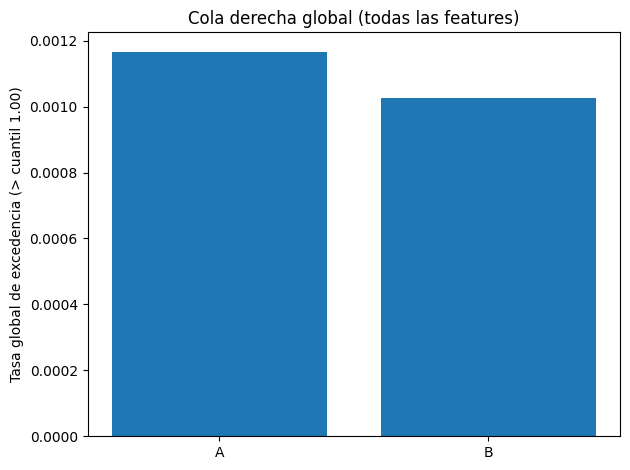

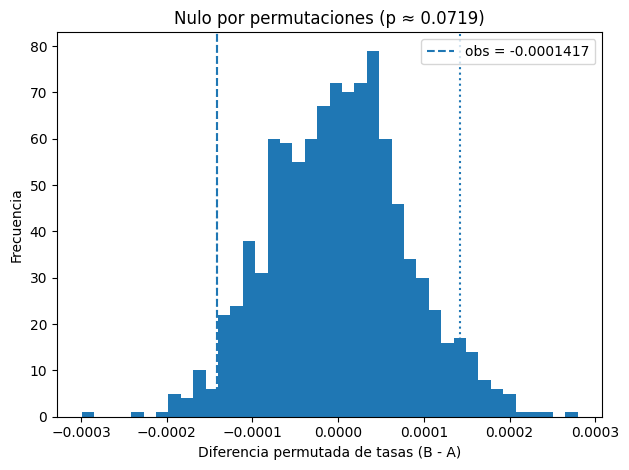

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binomtest

dfA = train_controls_df
dfB = train_cases_df
# -----------------------------
# Parámetros
# -----------------------------
u_q = 0.999           # cuantil para definir cola derecha
B = 1000             # permutaciones (sube/baja según recursos)
block = 5000         # columnas por bloque para reducir memoria
rng = np.random.default_rng(0)

# -----------------------------
# Alinear columnas y preparar
# -----------------------------
common = dfA.columns.intersection(dfB.columns)
A = dfA[common]
B_ = dfB[common]
nA, nB = len(A), len(B_)
m = len(common)
assert m > 0, "No hay columnas comunes entre dfA y dfB."

# Umbral por feature (pool A∪B)
u = pd.concat([A, B_], axis=0).quantile(u_q)

# -----------------------------
# Conteo de excedencias por muestra (sumando TODAS las features)
# -----------------------------
def row_exceed_counts(df, u, block=5000):
    counts = np.zeros(df.shape[0], dtype=np.int64)
    cols = df.columns
    for i in range(0, len(cols), block):
        cs = cols[i:i+block]
        ub = u[cs]
        # booleans por bloque -> suma por fila -> acumula
        counts += df[cs].gt(ub, axis=1).sum(axis=1).to_numpy()
    return counts

row_exc_A = row_exceed_counts(A, u, block=block)   # shape (nA,)
row_exc_B = row_exceed_counts(B_, u, block=block)  # shape (nB,)

# Tasas globales de excedencia (sobre todas las celdas grupo×features)
rateA = row_exc_A.sum() / (nA * m)
rateB = row_exc_B.sum() / (nB * m)
diff_obs = rateB - rateA

# -----------------------------
# Test global por permutaciones
# -----------------------------
row_exc_all = np.concatenate([row_exc_A, row_exc_B])  # por muestra (A luego B)

perm_diffs = np.empty(B, dtype=float)
for b in range(B):
    perm = rng.permutation(row_exc_all)
    A_part = perm[:nA]
    B_part = perm[nA:]
    perm_diffs[b] = (B_part.mean() - A_part.mean()) / m  # diferencia de fracción de excedencias

p_perm = (np.sum(np.abs(perm_diffs) >= abs(diff_obs)) + 1) / (B + 1)

print(f"Tasa global A (>q{u_q:.2f}): {rateA:.6f}")
print(f"Tasa global B (>q{u_q:.2f}): {rateB:.6f}")
print(f"Diferencia B-A: {diff_obs:.6f}")
print(f"p-valor (permutaciones): {p_perm:.6g}")

# -----------------------------
# (Opcional) Test global alternativo (sign test sobre Δq0.99 por feature)
# -----------------------------
qA = A.quantile(0.99)
qB = B_.quantile(0.99)
k = int((qB > qA).sum())
p_sign = binomtest(k, n=m, p=0.5, alternative="two-sided").pvalue
print(f"[Opcional] Sign test sobre Δq0.99: k={k}/{m} features con qB>qA; p={p_sign:.6g}")

# -----------------------------
# PLOTS (globales)
# -----------------------------

# (1) Barras: tasas globales de excedencia
plt.figure()
plt.bar(["A", "B"], [rateA, rateB])
plt.ylabel(f"Tasa global de excedencia (> cuantil {u_q:.2f})")
plt.title("Cola derecha global (todas las features)")
plt.tight_layout()
plt.show()

# (2) Distribución nula permutada vs observado
plt.figure()
plt.hist(perm_diffs, bins=40)
plt.axvline(diff_obs, linestyle="--", label=f"obs = {diff_obs:.4g}")
plt.axvline(-abs(diff_obs), linestyle=":")
plt.axvline(+abs(diff_obs), linestyle=":")
plt.xlabel("Diferencia permutada de tasas (B - A)")
plt.ylabel("Frecuencia")
plt.title(f"Nulo por permutaciones (p ≈ {p_perm:.3g})")
plt.legend()
plt.tight_layout()
plt.show()


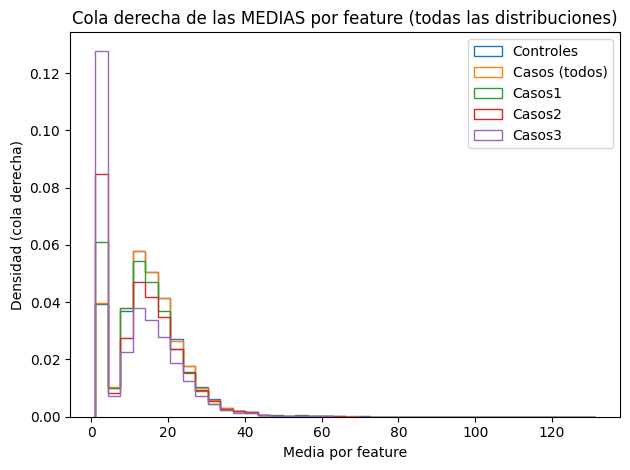

Umbral de cola (z) = cuantil 0.95 del pool z+: 1.692
Tasas de excedencia de z por grupo (>u_z):


,rate_z>u,count_z>u,total_feats
Controles,0.009016,2885,320000
Casos (todos),0.007238,2316,320000
Casos1,0.010981,3514,320000
Casos2,0.060584,19387,320000
Casos3,0.013288,4252,320000


Test global chi-cuadrado (r×2) sobre colas derechas de z: chi2=33220.1688, dof=4, p=0


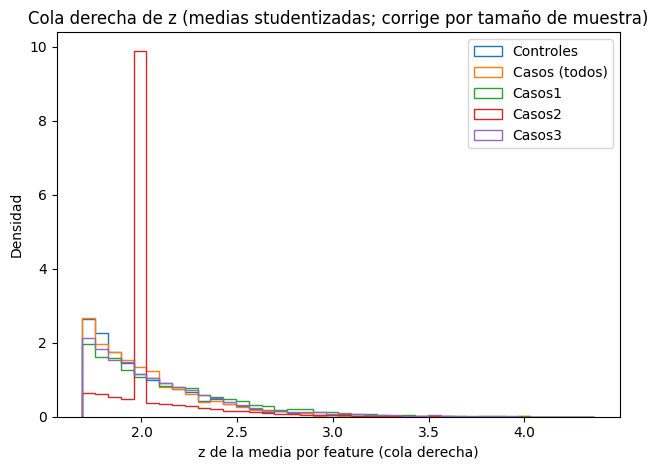

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

df_controles = train_controls_df
df_casos_todos = train_cases_df
df_casos1 = pd.read_csv("/home/77462217B/lois/AAImageneAnomalyDetection/outcomes/REC/heavymodelv1/All/StdPlus1ScoreMic10CasMSE.csv")
df_casos2 = pd.read_csv("/home/77462217B/lois/AAImageneAnomalyDetection/outcomes/REC/heavymodelv1/All/StdPlus1ScoreMic5CasMSE.csv")
df_casos3 = pd.read_csv("/home/77462217B/lois/AAImageneAnomalyDetection/outcomes/REC/heavymodelv1/All/StdPlus1ScoreMic3CasMSE.csv")
# =========================================
# 1) Define tus DataFrames aquí
#    (filas = muestras, columnas = features)
# =========================================
dfs = {
    "Controles": df_controles,       # <-- REEMPLAZA
    "Casos (todos)": df_casos_todos, # <-- REEMPLAZA
    "Casos1": df_casos1,             # <-- REEMPLAZA
    "Casos2": df_casos2,             # <-- REEMPLAZA
    "Casos3": df_casos3,             # <-- REEMPLAZA
}

# =========================================
# 2) Medias por feature y cola derecha de las MEDIAS (visualización)
# =========================================
# Intersección de columnas
common = None
for df in dfs.values():
    cols = set(df.columns)
    common = cols if common is None else (common & cols)
common = sorted(list(common))
assert len(common) > 0, "No hay features comunes en todos los dataframes."

# Medias por feature (por grupo)
means = {name: df[common].mean(axis=0, skipna=True) for name, df in dfs.items()}
means_df = pd.DataFrame(means, index=common).dropna(how="any")

# Histograma conjunto SOLO de la cola derecha de las MEDIAS
tail_q = 0.95
pooled_means = means_df.values.ravel()
u_mean = np.quantile(pooled_means, tail_q)
nbins = 40
vmax = float(np.max(pooled_means))
if vmax == u_mean:  # por si todas las medias son idénticas
    vmax = u_mean + 1e-8
bins = np.linspace(u_mean, vmax, nbins+1)

plt.figure()
for name in means_df.columns:
    vals = means_df[name].values
    vals = vals[vals >= u_mean]  # solo cola derecha
    plt.hist(vals, bins=bins, density=True, histtype="step", label=name)
plt.xlabel("Media por feature")
plt.ylabel("Densidad (cola derecha)")
plt.title("Cola derecha de las MEDIAS por feature (todas las distribuciones)")
plt.legend()
plt.tight_layout()
plt.show()

# =========================================
# 3) Test de significación para diferencias de colas,
#    corrigiendo por tamaños de muestra (studentizar la media)
#    z_{g,i} = (mean_{g,i} - mean_pooled_i) / (sd_{g,i} / sqrt(n_g))
#    Luego comparamos colas derechas de estos z por grupos (chi-cuadrado r×2)
# =========================================
# n y sd por feature y grupo
n = {name: df[common].count(axis=0) for name, df in dfs.items()}
sd = {name: df[common].std(axis=0, ddof=1) for name, df in dfs.items()}
n_df = pd.DataFrame(n, index=common)
sd_df = pd.DataFrame(sd, index=common)

# media "pooled" ponderada por n (por feature)
sum_n = n_df.sum(axis=1).replace(0, np.nan)
weighted_sum = sum((means_df[c]*n_df[c] for c in means_df.columns))
weighted_sum = pd.concat(weighted_sum, axis=1).sum(axis=1) if isinstance(weighted_sum, list) else weighted_sum
mean_pooled = weighted_sum / sum_n

# z-scores de la media por grupo (respecto a la mean_pooled del feature)
eps = 1e-12
z_df = pd.DataFrame(index=common, columns=means_df.columns, dtype=float)
for name in means_df.columns:
    se = sd_df[name] / np.sqrt(n_df[name].clip(lower=1))
    z_df[name] = (means_df[name] - mean_pooled) / (se.replace(0, np.nan) + eps)

# Cola derecha de los z (solo valores positivos)
z_pos = z_df.copy()
z_pos[z_pos < 0] = np.nan
pooled_zpos = z_pos.values.ravel()
pooled_zpos = pooled_zpos[~np.isnan(pooled_zpos)]
if pooled_zpos.size == 0:
    print("No hay z>0; no se puede evaluar cola derecha de z.")
else:
    u_z = np.nanquantile(pooled_zpos, tail_q)

    # Conteos de excedencia por grupo: z > u_z
    counts_exceed = (z_pos > u_z).sum(axis=0)
    totals = pd.Series([z_pos.shape[0]]*z_pos.shape[1], index=z_pos.columns)  # mismo nº de features para todos
    rates = counts_exceed / totals

    # Tabla r×2 y chi-cuadrado
    contingency = np.column_stack([counts_exceed.values, (totals - counts_exceed).values])
    chi2, p_chi2, dof, _ = chi2_contingency(contingency, correction=False)
    print(f"Umbral de cola (z) = cuantil {tail_q:.2f} del pool z+: {u_z:.4g}")
    print("Tasas de excedencia de z por grupo (>u_z):")
    display(pd.DataFrame({"rate_z>u": rates, "count_z>u": counts_exceed, "total_feats": totals}))
    print(f"Test global chi-cuadrado (r×2) sobre colas derechas de z: chi2={chi2:.4f}, dof={dof}, p={p_chi2:.6g}")

    # Plot de la cola derecha de z (visual)
    zmax = float(np.nanmax(pooled_zpos))
    if zmax == u_z:
        zmax = u_z + 1e-8
    zbins = np.linspace(u_z, zmax, nbins+1)

    plt.figure()
    for name in z_pos.columns:
        vals = z_pos[name].values
        vals = vals[~np.isnan(vals)]
        vals = vals[vals >= u_z]
        plt.hist(vals, bins=zbins, density=True, histtype="step", label=name)
    plt.xlabel("z de la media por feature (cola derecha)")
    plt.ylabel("Densidad")
    plt.title("Cola derecha de z (medias studentizadas; corrige por tamaño de muestra)")
    plt.legend()
    plt.tight_layout()
    plt.show()
